In [1]:
import pandas as pd
import numpy as np
import hvplot.xarray
import datetime as dt
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/DataAccess/Utilities')
import PreProcess_Utils as pputil

sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Modelling/Utilities')
import Snow_Utils as snow_util

In [2]:
from dask.distributed import LocalCluster

cluster = LocalCluster(n_workers = 10, threads_per_worker = 10, memory_limit = 0) # Refined through testing, removing memory_limit is important
client = cluster.get_client()
client # Can open in other window by clicking 'Dashboard' link below

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 100,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65287,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:65390,Total threads: 10
Dashboard: http://127.0.0.1:65392/status,Memory: 0 B
Nanny: tcp://127.0.0.1:65291,


2025-03-14 19:46:58,685 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ca64fc42423cf4c1971227104600ff19 initialized by task ('rechunk-merge-where-rechunk-transfer-ec5783ed54943e7069153ad69c852544', 0, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:65374
2025-03-14 19:47:21,452 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ca64fc42423cf4c1971227104600ff19 deactivated due to stimulus 'task-finished-1741996041.307577'
2025-03-14 19:48:32,795 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ca64fc42423cf4c1971227104600ff19 initialized by task ('rechunk-merge-where-rechunk-transfer-ec5783ed54943e7069153ad69c852544', 0, 0, 0, 31, 0, 0) executed on worker tcp://127.0.0.1:65374
2025-03-14 19:48:44,733 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ca64fc42423cf4c1971227104600ff19 deactivated due to stimulus 'task-finished-1741996124.703944'
2025-03-14 19:58:04,208 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ca64fc42423cf4c1

In [3]:
#tile_stats = pd.read_csv(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\IMS (1 km)\Outputs\old\2024\tiles_IMS_SnowDynamics4HLS.csv", index_col = 0)
tile_stats = pd.read_csv(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\IMS (1 km)\Outputs\tiles_IMS_SnowDynamics4HLS.csv", index_col = 0)
tile_stats # Note, not every tile (snow free removed)

,smin_avg,smax_avg,sstart_avg,send_avg,send_last,sstart_first
0,209.85715,34.500000,4.166666,61.500000,90.0,335.0
1,217.14285,37.166668,3.333333,68.500000,90.0,335.0
2,209.71428,34.666668,10.000000,61.833332,90.0,335.0
3,194.42857,29.833334,35.333332,69.333336,90.0,335.0
4,209.57143,36.833332,5.833334,60.000000,90.0,335.0
...,...,...,...,...,...,...
3386,230.71428,37.833332,-133.285720,230.714280,NaN,NaN
3387,227.14285,39.166668,-136.857150,227.142850,NaN,NaN
3388,224.71428,37.000000,-139.285720,224.714280,NaN,NaN
3389,229.71428,33.666668,-134.285720,229.714280,NaN,NaN


In [4]:
tile = 2990 # From canadaFishnet_CanVec_60km
w_s = 2019 # Year that winter ends
w_e = 2020 # Year that winter starts
winterYear = str(w_s)[2:] + str(w_e)[2:] 

path = 'F:/HLS/Canada/Tiles60km/fmask/'

In [5]:
tile_stats.iloc[tile]

smin_avg        235.571430
smax_avg         49.500000
sstart_avg     -110.166664
send_avg        194.166670
send_last       218.000000
sstart_first    243.000000
Name: 2990, dtype: float64

# Full Process to Winter Year Snow Dynamics

In [6]:
%%time
c_s = pputil.uploadNC(path + str(w_s) + '/fmask_' + str(tile) + '_' + str(w_s) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})
c_s

CPU times: total: 15.6 ms
Wall time: 826 ms


<xarray.DataArray 'stackstac-186cff161c1659af1ede918c36aabbc8' (time: 252,
                                                                band: 1,
                                                                y: 2001, x: 2001)> Size: 1GB
dask.array<open_dataset-stackstac-186cff161c1659af1ede918c36aabbc8, shape=(252, 1, 2001, 2001), dtype=uint8, chunksize=(1, 1, 2001, 2001), chunktype=numpy.ndarray>
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 16kB 4.09e+05 4.09e+05 ... 4.689e+05 4.69e+05
  * y              (y) float64 16kB 2.575e+06 2.575e+06 ... 2.515e+06 2.515e+06
    constellation  (time) <U3 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 2kB 2019-03-10 ... 2019-10-03
Attributes:
    spec:        RasterSpec(epsg=3979, bounds=(408960, 2515260, 468990, 25752...
    crs:         epsg:3979
    transform:   [ 3.00000e+01  0.00000e+00  4.08960e+05  0.00000e+00 -3.0000...
    resolution:  30

In [7]:
%%time
c_e = pputil.uploadNC(path + str(w_e) + '/fmask_' + str(tile) + '_' + str(w_e) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})
c_e

CPU times: total: 0 ns
Wall time: 23.1 ms


<xarray.DataArray 'stackstac-5b032c074abeee766df5258664e1f282' (time: 242,
                                                                band: 1,
                                                                y: 2001, x: 2001)> Size: 969MB
dask.array<open_dataset-stackstac-5b032c074abeee766df5258664e1f282, shape=(242, 1, 2001, 2001), dtype=uint8, chunksize=(1, 1, 2001, 2001), chunktype=numpy.ndarray>
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 16kB 4.09e+05 4.09e+05 ... 4.689e+05 4.69e+05
  * y              (y) float64 16kB 2.575e+06 2.575e+06 ... 2.515e+06 2.515e+06
    constellation  (time) <U3 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 2kB 2020-03-07 ... 2020-10-02
Attributes:
    spec:        RasterSpec(epsg=3979, bounds=(408960, 2515260, 468990, 25752...
    crs:         epsg:3979
    transform:   [ 3.00000e+01  0.00000e+00  4.08960e+05  0.00000e+00 -3.0000...
    resolution:  30

In [8]:
%%time
snowCube = snow_util.annualFmask2SnowCube(c_s, c_e, yrs = 2, verbose = True) # yrs = 1, doy = doy
# Want to use 2 year cube to help get better results due to date gaps
snowCube

Initial Fmask time-steps: Start (n = 252), End (n = 242).
Made decision on same-day observations (L30vS30): Start (n = 193), End (n = 184).
Combined snow cube (n = 377).
Removed time-steps above 99% unclear pixels (n = 249).
Reclassifed (Snow = 1, Non-snow = 0, Unclear = NaN)
CPU times: total: 2.83 s
Wall time: 11.7 s


<xarray.DataArray 'stackstac-186cff161c1659af1ede918c36aabbc8' (time: 249,
                                                                y: 2001, x: 2001)> Size: 4GB
dask.array<where, shape=(249, 2001, 2001), dtype=float32, chunksize=(1, 2001, 2001), chunktype=numpy.ndarray>
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 16kB 4.09e+05 4.09e+05 ... 4.689e+05 4.69e+05
  * y            (y) float64 16kB 2.575e+06 2.575e+06 ... 2.515e+06 2.515e+06
  * time         (time) datetime64[ns] 2kB 2019-03-10 2019-03-11 ... 2020-10-02
    spatial_ref  int64 8B 0

In [9]:
thresh = 2 # Originally 3 but in some situations leads to extra uncertainty


if np.isnan(tile_stats.loc[tile, 'send_last']) == True:
    implausible_snow = []
else: # Week buffer from latest recorded end date and earliest recorded start date
    implausible_snow = [int(tile_stats.loc[tile, 'send_last']) + 7, int(tile_stats.loc[tile, 'sstart_first']) - 7]

implausible_snow

[225, 236]

In [10]:
# %%time
# snowCube_c = snow_util.cleanSnowCube(snowCube, implausible_snow = implausible_snow, thresh = thresh)
# snowCube_c

In [11]:
# %%time
# snowCube_c = snow_util.dailySnowCube(snowCube_c, doy = int(tile_stats.loc[tile, 'smin_avg']), verbose = True)
# snowCube_c

In [12]:
# %%time
# snowDynamics = snow_util.dailySnowCube2SnowDynamics(snowCube_c, uncertainty = True, verbose = True) # Default settings
# snowDynamics

# Load Snow Cube

In [13]:
# %%time
# snowCube = pputil.loadXR(snowCube)
# snowCube

# Select good pixel(s)?

In [14]:
x = 667#np.random.randint(0, snowCube.shape[1])
print(x)
y = 1791 #np.random.randint(0, snowCube.shape[2])
print(y)

print(snowCube[:, x, y]['x'].values) #.rio.set_spatial_dims('x', 'y').rio.reproject('EPSG:4326')
print(snowCube[:, x, y]['y'].values)

(snowCube[:, x, y].rename('Snow Cube') # To plot with hvplot
                  .dropna(dim = 'time') # Prepare for daily resample
                  .resample(time = '1D').interpolate('linear').astype('float32') # Linear daily resample
                  # Reindex to fill 2 year time-series?
                  .hvplot(height = 600, width = 1500) * # Drop na and interpolate na to see full picture

(snowCube[:, x, y].hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points

667
1791
462705.0
2555265.0


:Overlay
   .Curve.I   :Curve   [time]   (Snow Cube)
   .Scatter.I :Scatter   [time]   (stackstac-186cff161c1659af1ede918c36aabbc8)

In [15]:
# dates = snowCube[:, x, y].time.values
# dates = [date[0:10] for date in np.datetime_as_string(dates)]

# obs = snowCube[:, x, y].values
# obs = [ob.item() for ob in obs]

# {dates: obs for dates, obs in zip(dates, obs)}

In [16]:
# snowCube[:, x, y]

## Method

### cleanSnowCube
- Resetting cumsum, threshold = 2

In [17]:
%%time

thresh = 2

snowCube_c = snow_util.cleanSnowCube(snowCube, form = 'binary', temporal = 'gaps', implausible_snow = implausible_snow, thresh = thresh) # snowCube[:, x-5:x+5, y-5:y+5]
#snowCube_c

(snowCube_c[:, x, y].rename('Snow Cube') # To plot with hvplot # [:, 5, 5]
                    .dropna(dim = 'time') # Prepare for daily resample
                    .resample(time = '1D').interpolate('linear').astype('float32') # Linear daily resample
                    # Reindex to fill 2 year time-series?
                    .hvplot(height = 600, width = 1500) * # Drop na and interpolate na to see full picture
 
(snowCube_c[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # [:, 5, 5]

Set all observations to non-snow between implausible snow dates (08-13 to 08-24).
Calculated cumulative sum that resets when non-snow is found.
Identified periods when 2+ consecutive snow observations occured (skipping NaN).
Created flipped snowCube to identify non-snow periods.
Calculated cumulative sum that resets when snow is found.
Identified periods when 2+ consecutive non-snow observations occured (skipping NaN).
Removed (NaN) snow and non-snow periods below 2 consecutive observations.
CPU times: total: 30.5 s
Wall time: 2min 22s


:Overlay
   .Curve.I   :Curve   [time]   (Snow Cube)
   .Scatter.I :Scatter   [time]   (s)

In [18]:
# # Just filter to 1 year for publication
# doy = int(tile_stats.loc[tile, 'smin_avg'])

# # Filter and (if needed) Reindex
# yr2 = int(snowCube_c.time.dt.year[-1]) # Last year represented in cube

# # Convert day-of-year to filterable strings
# if ((yr2 - 1) / 4).is_integer() == False: # Not a leap year
#     date1 = dt.datetime(yr2 - 1, 1, 1) + dt.timedelta(doy) # Day after first year
# if ((yr2 - 1) / 4).is_integer() == True: # Leap year
#     date1 = dt.datetime(yr2 - 1, 1, 1) + dt.timedelta(doy + 1) # Day after first year
# if (yr2 / 4).is_integer() == False: # Not a leap year (doy )
#     date2 = dt.datetime(yr2, 1, 1) + dt.timedelta(doy - 1) # Day-of-year next year
# if (yr2 / 4).is_integer() == True: # Leap year
#     date2 = dt.datetime(yr2, 1, 1) + dt.timedelta(doy) # Day-of-year next year

# start = f'{date1.year}-{date1.month:02d}-{date1.day:02d}'
# end =  f'{date2.year}-{date2.month:02d}-{date2.day:02d}'

# # Filter
# snowCube_c = snowCube_c.sel(time = slice(start, end))
# snowCube_c

In [19]:
# (snowCube_c[:, x, y].rename('Snow Cube') # To plot with hvplot # snowCube_c[:, 5, 5]
#                     .dropna(dim = 'time') # Prepare for daily resample
#                     .resample(time = '1D').interpolate('linear').astype('float32') # Linear daily resample
#                     # Reindex to fill 2 year time-series?
#                     .hvplot(height = 600, width = 1500) * # Drop na and interpolate na to see full picture
 
# (snowCube_c[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # snowCube_c[:, 5, 5]

In [ ]:
# snowCube_c[:, 5, 5]

In [21]:
%%time

snowCube_c = snow_util.dailySnowCube(snowCube_c, doy = int(tile_stats.loc[tile, 'smin_avg']), verbose = True)
#snowCube_c

(snowCube_c[:, x, y].rename('Snow Cube') # To plot with hvplot # snowCube_c[:, 5, 5]
                    .hvplot(height = 600, width = 1200) * # Drop na and interpolate na to see full picture

(snowCube_c[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # snowCube_c[:, 5, 5]

Filled in all NaNs in snowCube with linearly interpolated values in time.
Resampled to daily snowCube (2019-03-10 to 2020-10-02, n = 573) using linear interpolation.
Filtered to winter year (2019-08-24 to 2020-08-23, n = 366).
Reinidexing not required since daily snowCube already contains all possible dates.
CPU times: total: 21.9 s
Wall time: 1min 55s


:Overlay
   .Curve.I   :Curve   [time]   (Snow Cube)
   .Scatter.I :Scatter   [time]   (s)

In [22]:
# # Binary cube
# snowCube_b = xr.where(snowCube_c >= 0.4999, 1, snowCube_c) # If no uncertainty (e.g., IMS - don't need this)
# snowCube_b = xr.where(snowCube_c < 0.4999, 0, snowCube_b) # 0.4999 accounts for weird rounding in some cases

# (snowCube_b[:, x, y].rename('Binary Snow Cube') # To plot with hvplot # snowCube_b[:, 5, 5]
#                     .hvplot(height = 600, width = 1200) * # Drop na and interpolate na to see full picture

# (snowCube_b[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # snowCube_b[:, 5, 5]

In [23]:
# # Uncertainty cube
# snowCube_u = xr.where((snowCube_c < 0.005) | (snowCube_c > 0.995), 0, snowCube_c)
# snowCube_u = xr.where((snowCube_c >= 0.005) & (snowCube_c <= 0.995) , 1, snowCube_u) 

# (snowCube_u[:, x, y].rename('Uncertainty Snow Cube') # To plot with hvplot # snowCube_u[:, 5, 5]
#                     .hvplot(height = 600, width = 1200) * # Drop na and interpolate na to see full picture

# (snowCube_u[:, x, y].rename('s').hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points # snowCube_u[:, 5, 5]

### snowDynamics stats

In [24]:
%%time

snowDynamics = snow_util.dailySnowCube2SnowDynamics(snowCube_c, products = ['start', 'end', 'length', 'periods', 'status'], uncertainty = True, verbose = True)
#snowDynamics

print('Snow status: ' + str(snowDynamics['snow_status'][x,y].values)) # [5,5]
print('Snow periods: ' + str(snowDynamics['snow_periods'][x,y].values)) # [5,5]
print('Snow start: ' + str(snowDynamics['snow_start'][x,y].values)) # [5,5]
print('Snow start uncertainty: ' + str(snowDynamics['snow_start_u'][x,y].values)) # [5,5]
print('Snow end: ' + str(snowDynamics['snow_end'][x,y].values)) # [5,5]
print('Snow end uncertainty: ' + str(snowDynamics['snow_end_u'][x,y].values)) # [5,5]
print('Snow length: ' + str(snowDynamics['snow_length'][x,y].values)) # [5,5]
print('Snow length uncertainty: ' + str(snowDynamics['snow_length_u'][x,y].values)) # [5,5]

Created empty snowDynamics Dataset to fill.
Created binary snowCube (>= 0.5 = 1, < 0.5 = 0).
Calculated cumulative sum of binary snowCube (used in multiple products).
Added snow cover start date (# days from Dec 31) to snowDynamics.
Added snow cover end date (# days from Dec 31) to snowDynamics.
Added snow cover length (# days with snow cover) to snowDynamics.
Added snow period count (# seperated snow periods) to snowDynamics.
Added snow status (0 = Regular fall/melt, 1 = Perennial, 2 = Inconsistent perennial, 3 = Snow free) to snowDynamics.
Created uncertainty snowCube (>= 0.005 & <= 0.995 = 1, else = 0).
Used 99 day gap between latest snow start (2019-12-30) and earliest snow end (2020-04-07) to find winter year split day: 2020-02-17.
Added snow start uncertainty (# days between last non-snow and first snow observation / 2) to snowDynamics.
Added snow end uncertainty (# days between last snow and first non-snow observation / 2) to snowDynamics.
Added snow length uncertainty (total # 

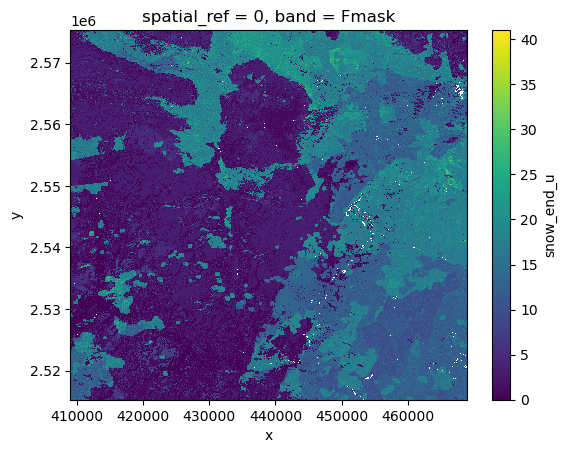

In [25]:
snowDynamics['snow_end_u'].plot()